# Downloads + Imports

In [ ]:
!pip -q install tensorflow_addons
!pip install optuna
!pip -q install stellargraph
!pip install -q neptune-client==0.4.132 neptune-contrib[monitoring]==0.25.0

In [ ]:
## download deepwalk embeds 
!gdown --id 1isrA9Q_ivusLhfpgncbS5g51c8lX5XzK
## download author embeddings (avg,std,minmax)
!wget -c https://icecube-eu-290.icedrive.io/download?p=bZ_sA1Z5mCom.j0ZWsBXrB4ZaK3TBlqQzZj9tp7mOdjD6HTKsIng0zmgrpkDUo_Wcfwh9y5sRy249IP3Ny1RIARlGP7WGq6xziTgGlQU0OKTDNaz_jXpfYbTGm6Rawau9sM.jie8vpT.SB.MG_DWASLCWDvPByqJ_E8urknzVjiCh1LNKqtUdxFh8qwlds6L09KZG2g3J0PwD2ec2y0Djg-- -O  "author_embeds_full2.csv"
## download chtayra embedding:
!gdown --id 1HRM1b7-CcE4G6zadLS-LZPaCWhwhoFWi
# # ## download node cluster data
!gdown --id 1-1MsoyleTbh1ns5y0OOz91AJc0vJA5BX

## download competition data
!gdown --id "1zAHe0nRAxzTsrBm3pNfqjQZeHd-uKgTd"
!unzip -o -q "/content/altegrad-2020.zip"



Downloading...
From: https://drive.google.com/uc?id=1isrA9Q_ivusLhfpgncbS5g51c8lX5XzK
To: /content/colab_net_deepwalk_embeddings.txt
167MB [00:01, 118MB/s]
--2021-03-03 18:09:26--  https://icecube-eu-290.icedrive.io/download?p=bZ_sA1Z5mCom.j0ZWsBXrB4ZaK3TBlqQzZj9tp7mOdjD6HTKsIng0zmgrpkDUo_Wcfwh9y5sRy249IP3Ny1RIARlGP7WGq6xziTgGlQU0OKTDNaz_jXpfYbTGm6Rawau9sM.jie8vpT.SB.MG_DWASLCWDvPByqJ_E8urknzVjiCh1LNKqtUdxFh8qwlds6L09KZG2g3J0PwD2ec2y0Djg--
Resolving icecube-eu-290.icedrive.io (icecube-eu-290.icedrive.io)... 46.165.242.15
Connecting to icecube-eu-290.icedrive.io (icecube-eu-290.icedrive.io)|46.165.242.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Downloading...
From: https://drive.google.com/uc?id=1HRM1b7-CcE4G6zadLS-LZPaCWhwhoFWi
To: /content/author_keywds_AHMED.csv
283MB [00:01, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1MsoyleTbh1ns5y0OOz91AJc0vJA5BX
To: 

In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import NovoGrad,Lookahead

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout , BatchNormalization ,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.nn import leaky_relu
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import stellargraph as sg
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE


from stellargraph.layer.ppnp import PPNP
from stellargraph.layer.appnp import APPNP

from stellargraph import datasets
from stellargraph.utils import plot_history

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection

import networkx as nx
import optuna



# Load data + Pre processing

In [ ]:
author_embeds = pd.read_csv("author_embeds_full2.csv")
author_embeds.rename(columns = {"Unnamed: 0":"authorID"},inplace=True)
author_embeds.set_index(author_embeds['authorID'],inplace=True)
author_embeds.drop(columns=['authorID'],inplace=True)
author_embeds.head()

,avg 0,avg 1,avg 2,avg 3,avg 4,avg 5,avg 6,avg 7,avg 8,avg 9,avg 10,avg 11,avg 12,avg 13,avg 14,avg 15,avg 16,avg 17,avg 18,avg 19,avg 20,avg 21,avg 22,avg 23,avg 24,avg 25,avg 26,avg 27,avg 28,avg 29,avg 30,avg 31,avg 32,avg 33,avg 34,avg 35,avg 36,avg 37,avg 38,avg 39,...,max 217,max 218,max 219,max 220,max 221,max 222,max 223,max 224,max 225,max 226,max 227,max 228,max 229,max 230,max 231,max 232,max 233,max 234,max 235,max 236,max 237,max 238,max 239,max 240,max 241,max 242,max 243,max 244,max 245,max 246,max 247,max 248,max 249,max 250,max 251,max 252,max 253,max 254,max 255,n_papers
authorID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1036332,-0.670915,-0.359066,0.032644,0.001299,0.516241,-0.401442,-0.266719,-0.309738,-0.317130,0.317681,-0.330467,0.612775,-0.021864,-0.729525,-0.032873,0.296621,-0.117286,-0.256655,0.706496,-0.183294,-1.307308,0.519499,-0.647021,0.229126,0.537920,0.096529,0.169272,0.194358,0.874101,-0.068565,-0.514697,-0.346802,0.035213,-0.203666,-0.216070,-0.195695,-0.521439,0.021314,-0.365639,0.479228,...,0.499690,0.544143,-0.180028,0.180431,-0.009263,-0.745323,-0.227080,0.292408,-0.240492,0.239435,-0.225935,0.376984,-0.172546,-0.811954,-0.495904,-0.084609,-0.433649,0.375203,-0.835952,-0.211374,0.526285,0.781766,0.236068,-0.035206,-0.580591,0.462592,0.597586,0.184451,0.802938,-0.162514,-0.297305,0.564505,1.189805,0.779893,0.646247,-0.151325,0.311772,-0.350208,0.281016,10.0
1101850,0.174118,-0.418902,0.126907,-0.434909,0.057360,-0.896717,0.104900,-0.071798,0.058149,-0.162548,-0.446979,0.057747,0.534189,-0.334704,-0.095730,-0.196843,1.432983,0.573235,0.092543,-0.137559,-1.550742,-0.268918,-0.264333,0.146961,-0.152437,0.257579,0.177396,0.009939,0.566907,0.520262,-0.442662,-0.034450,-1.323437,0.642263,-0.510872,-0.719326,0.521323,0.450722,-0.078295,0.110865,...,-0.238680,0.787703,-0.319154,-0.201167,-0.531976,-0.758207,-0.194286,-0.754079,0.723428,0.309464,-0.503141,0.033638,0.057217,-1.088598,0.526985,0.141639,0.412071,0.126281,-0.125068,-0.459249,0.299862,-0.397002,-0.182931,-0.719578,-0.395005,-0.365402,0.480954,-0.213679,0.428882,-0.119099,0.420797,0.039515,0.934612,-0.189791,0.797531,0.288263,0.212681,0.381630,-0.334163,10.0
1336878,-0.457677,-0.075856,-0.706770,0.232660,-0.142577,0.157583,-0.518147,0.305940,-0.658546,0.092074,-0.138651,-0.315813,0.693731,-0.100878,-0.459728,0.764480,0.230007,0.411774,-0.775120,0.495443,0.641672,0.166622,1.113050,-0.514069,-0.108101,0.563612,0.163444,1.052690,-0.263543,0.617824,-0.512447,-0.632055,-1.057613,0.164391,-0.715569,-0.747823,0.537585,-0.116105,-0.205757,-0.311762,...,0.320401,0.522424,0.200598,-0.037448,-1.278617,0.799516,0.575198,-0.877052,0.635505,0.795541,-0.157591,-1.067630,-0.596872,-1.084220,-0.044821,0.102162,-0.929092,0.465053,-1.074324,-0.832807,0.240991,0.076727,0.734057,-0.662209,-1.222314,-0.415042,0.937100,-0.198996,0.577093,-0.224453,0.332408,0.403299,0.177534,0.442314,0.617622,-0.365555,1.018285,-0.881188,0.270753,9.0
1515524,0.007245,0.082101,0.480947,-0.876973,0.781694,0.141359,0.211259,0.517827,0.427663,-0.276976,-0.729186,0.689607,-0.346114,-0.488435,-0.107165,0.679893,-0.174342,-0.128430,-0.767647,-0.123611,-0.598480,0.562878,0.065125,-0.036792,-0.444272,0.644067,-0.392876,-0.186923,0.489799,-0.208338,-0.433074,0.113006,-0.877710,0.615984,-0.539929,-0.419203,-0.064564,0.162514,0.431589,0.370070,...,-0.064631,0.465737,-0.277834,-0.039925,-0.605255,0.663218,0.549541,0.555771,-0.323215,0.490686,-0.107345,0.499525,0.028085,-0.508488,-0.249464,-0.306733,-0.254856,-0.032120,0.156723,-0.049597,0.677438,-0.433834,0.738120,-0.566311,-0.149444,0.222702,0.109430,-0.059463,0.618458,-0.496747,-0.107600,0.628540,-0.421982,0.591190,-0.241068,0.308011,0.698082,-0.528992,-0.688370,10.0
1606427,-0.975989,0.187017,-0.988799,1.767161,0.769870,-3.763815,0.132515,-2.558197,-0.826874,2.000220,-2.660278,1.376043,0.947726,0.849836,-0.564574,0.569658,1.704702,0.489982,0.451404,0.113303,-1.191751,1.018100,0.218787,-0.062853,1.258

In [ ]:
from sklearn.decomposition import PCA

pc = PCA(64)
non_avg = author_embeds.iloc[:,256:]
authors_mini = pc.fit_transform(non_avg)
authors_mini = pd.DataFrame(authors_mini,columns=["auth pca"+str(i) for i in range(64)],index=non_avg.index)
authors_mini.head()

,auth pca0,auth pca1,auth pca2,auth pca3,auth pca4,auth pca5,auth pca6,auth pca7,auth pca8,auth pca9,auth pca10,auth pca11,auth pca12,auth pca13,auth pca14,auth pca15,auth pca16,auth pca17,auth pca18,auth pca19,auth pca20,auth pca21,auth pca22,auth pca23,auth pca24,auth pca25,auth pca26,auth pca27,auth pca28,auth pca29,auth pca30,auth pca31,auth pca32,auth pca33,auth pca34,auth pca35,auth pca36,auth pca37,auth pca38,auth pca39,auth pca40,auth pca41,auth pca42,auth pca43,auth pca44,auth pca45,auth pca46,auth pca47,auth pca48,auth pca49,auth pca50,auth pca51,auth pca52,auth pca53,auth pca54,auth pca55,auth pca56,auth pca57,auth pca58,auth pca59,auth pca60,auth pca61,auth pca62,auth pca63
authorID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1036332,-1.888684,2.597460,-3.433860,-3.167465,0.334390,-0.784500,-0.515614,-0.659675,-0.064631,0.770067,-0.073511,-0.476651,-0.673218,-0.238873,-0.136046,-0.312369,0.279904,0.229094,0.266010,0.755295,-0.043433,0.605252,-1.349813,-0.135789,0.088865,0.093422,0.600559,0.874288,-0.787676,-0.261342,-0.201010,-0.870125,0.429543,-0.819759,-0.788371,-0.159981,-0.379147,0.872277,-0.794453,-0.798592,0.365841,-0.099546,-0.109948,-0.472190,0.462936,0.626468,-0.652985,-1.306869,0.294770,-0.184049,1.241711,0.432382,0.283727,-0.798514,0.269531,-0.405486,0.540251,0.680155,0.560018,0.139965,0.094844,-0.067875,0.229927,0.596025
1101850,-4.892186,-0.927624,3.559977,-2.071169,0.133569,-0.121129,2.099660,-1.282479,-0.141757,2.376634,0.743500,-1.366278,1.348864,-0.089638,-0.202142,-0.325724,0.697288,-0.302367,-1.063861,1.047689,0.151109,0.058921,-0.525410,-1.710185,-0.669846,1.675405,-1.003668,-0.913637,1.068482,-0.785899,-1.255753,0.085179,-0.238045,1.326020,0.712644,-0.596906,0.459797,-0.306317,-0.345320,0.459910,0.394832,1.242853,-1.335007,-0.500383,0.615085,-0.342108,0.623923,-0.383646,1.060320,-0.485733,-1.095889,0.645656,-0.529546,-0.320823,0.582986,-0.265075,0.522767,0.139836,0.942211,0.500402,-0.101058,-0.061338,-1.019036,0.787626
1336878,-3.996605,0.912660,3.227314,-0.415848,2.946198,1.063094,-0.565784,-1.200454,0.196007,0.540545,0.619977,-1.311934,1.694404,-0.828285,-1.785683,-0.512160,-0.927765,-1.934803,-0.959286,0.484097,-1.236353,0.154546,-0.263917,-1.160840,-0.819463,0.523413,-0.100531,0.062835,0.494515,0.722098,0.495595,1.582544,-0.098640,-0.661285,-0.308787,0.586518,-0.128868,0.556844,0.620096,-0.277864,0.431061,-1.698302,0.883061,-0.177758,1.594602,-1.163703,0.593336,-0.117988,0.729866,-2.000705,0.907523,-0.146293,-0.274439,-0.147894,0.022547,0.448054,-0.527059,-0.101904,0.430370,0.536216,-0.429230,1.200396,-0.224363,1.226513
1515524,-3.888946,-0.177399,1.045000,-1.251053,2.047506,-0.562977,-1.030665,0.079445,-0.825412,0.965286,-0.686187,0.537380,0.804977,-0.497985,3.058448,0.341666,-0.899289,0.083823,0.190240,-0.537165,0.196638,-1.437837,0.232475,0.318696,-0.165605,1.341709,-0.713093,-0.102414,1.417433,0.575318,0.126305,-0.565235,0.081869,0.223006,0.578729,-0.516715,-0.546091,-0.346460,0.388159,0.687787,0.241704,0.051588,0.548510,-0.592342,-0.344168,-0.136954,0.456785,0.338268,1.014596,0.540589,0.263777,0.080614,-0.320926,0.112856,0.024145,0.265165,-0.298112,0.348617,-0.167736,-0.116046,-0.023835,-0.093525,-0.273720,-0.127282
1606427,14.961643,1.738277,1.988560,-6.834096,-4.206595,2.139047,-2.518138,-1.278923,5.096857,0.508537,2.123072,-0.195582,-5.474321,2.057532,-2.179230,-0.778114,0.198619,2.291740,2.148350,1.546222,0.747195,-0.585824,0.258602,-0.687538,-1.800539,2.211969,-0.338183,1.778699,3.316535,-3.104122,0.178432,0.261691,-2.253872,3.499701,3.706689,1.592257,0.271211,-2.187355,-2.559459,1.255149,-0.973509,-1.492862,-0.230083,-0.432149,-2.007672,-0.636527,0.248641,-0.753043,-2.966186,-2.406484,-2.307063,-0.253537,0.055402,-0.240459,1.826808,-0.104640,-1.834434,-0.388971,0.980944,0.074474,3.287161,-0.193834,-0.466919,-0.373621


In [ ]:
node_cl = pd.read_csv("node_cluster_data.csv")
### DROP Categorical cluster node variable it's useless
to_drop = ['node_cluster_'+str(i) for i in range(1,75)] + ['author_node_number']
node_cl.drop(columns=to_drop,inplace=True)
#node_cl = node_cl[["authorID","degree","core_n","avg_nghbr_degree"]]
node_cl.set_index("authorID",inplace=True)
node_cl.head()

,c_mean,c_var,c_quantile_0%,c_quantile_10%,c_quantile_20%,c_quantile_30%,c_quantile_40%,c_quantile_50%,c_quantile_60%,c_quantile_70%,c_quantile_80%,c_quantile_90%,c_quantile_100%,degree,core_n,avg_nghbr_degree
authorID,,,,,,,,,,,,,,,,
2002218453,10.625000,12.993817,2.0,2.7,3.4,4.0,4.0,4.0,5.2,9.4,14.8,24.6,40.0,19,11,12.368421
1999212242,7.000000,5.000000,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,8,8,10.250000
2032640503,6.826087,6.393549,1.0,2.0,2.0,3.0,3.0,4.0,6.0,7.4,10.8,16.0,24.0,12,8,8.416667
2475931411,16.000000,31.892677,1.0,1.0,1.4,2.0,2.0,2.5,4.8,11.1,12.6,37.3,94.0,8,8,10.250000
2477743428,26.714285,44.481136,1.0,1.6,2.2,2.8,3.0,3.0,9.6,19.6,36.4,74.0,122.0,8,8,10.250000


In [ ]:
dw_emb = pd.read_csv('colab_net_deepwalk_embeddings.txt', sep=" " , skiprows=1, header=None)
dw_emb.columns = ['authorID' if i==0 else f'dw_cp{i}' for i in range(dw_emb.shape[1])]
#dw_emb.set_index("authorID",inplace=)


In [ ]:
n_papers = pd.DataFrame(author_embeds['n_papers'], columns=['n_papers'], index=author_embeds.index)
n_papers.head()

,n_papers
authorID,
1036332,10.0
1101850,10.0
1336878,9.0
1515524,10.0
1606427,1.0


In [ ]:
kw_emb = pd.read_csv("author_keywds_AHMED.csv")
kw_emb.head()

,authorID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,1036332,-0.001448,0.005915,-0.000509,-0.001444,0.004591,0.005749,-0.004986,-0.003163,-0.005998,-0.006371,0.001179,-0.004602,0.007034,-0.000548,-0.007070,-0.001693,0.000880,0.000797,0.002033,0.004233,-0.004055,-0.001624,-0.001595,0.004509,0.007585,-0.006311,-0.000999,-0.002036,-0.004088,0.002935,0.007257,-0.001903,-0.006215,0.007679,0.000152,-0.000554,-0.000112,0.004722,0.002766,-0.003548,-0.007417,0.006346,0.002415,-0.005626,0.000391,0.000503,0.004809,0.000520,0.002058,-0.005602,0.006533,0.005513,-0.001609,0.005013,0.002052,-0.003057,-0.005553,0.006534,-0.006660,0.005388,0.002876,0.006540,0.006745,0.007610
1,1101850,-0.004350,-0.005770,-0.004901,-0.003269,0.003187,0.003014,-0.002801,0.003896,-0.001379,0.006799,-0.000906,-0.005504,0.002971,-0.007459,-0.004891,-0.001497,-0.000926,-0.001727,-0.005587,-0.006067,-0.001501,0.007053,-0.005986,-0.001209,0.000466,0.001398,-0.000428,-0.001320,-0.003714,-0.004532,-0.006200,0.000738,0.001223,-0.004606,-0.004458,0.001919,0.002238,-0.006016,0.003875,0.002014,0.004882,0.000064,-0.006600,0.002346,0.005872,0.007262,-0.003594,-0.000818,0.001524,0.003670,-0.003555,0.007660,0.005929,-0.004833,-0.001249,-0.004434,-0.004301,0.001798,0.002644,-0.000286,-0.001975,0.000350,-0.001531,-0.003356
2,1336878,0.007272,0.001268,-0.004422,-0.005841,-0.002690,-0.000401,0.001919,-0.004113,0.001136,0.007156,0.000250,-0.004210,-0.001063,0.006351,0.007161,-0.006540,0.007320,-0.006076,0.007695,-0.003782,-0.001744,-0.003909,-0.003992,0.002415,-0.007480,-0.007161,-0.003385,-0.007214,0.006967,-0.004896,-0.001689,0.002751,0.002773,0.003575,-0.002886,0.002113,0.003545,-0.006258,-0.005767,0.006883,0.005591,-0.001869,0.000745,0.002099,-0.000348,0.004043,-0.005000,-0.004704,0.002866,0.001804,0.003345,-0.002383,-0.002857,0.006740,0.002607,-0.007753,-0.007416,0.000145,-0.003446,0.002858,-0.001515,-0.006126,-0.000309,0.003714
3,1515524,0.005060,-0.003722,0.004283,-0.002750,-0.000137,-0.004208,0.001779,0.005762,0.002427,0.000157,-0.004908,0.003978,0.001616,-0.002841,-0.000249,-0.003878,0.005836,-0.003951,0.007382,0.005743,0.006493,0.003315,-0.000081,0.001771,-0.005255,0.004866,-0.003454,-0.002683,-0.002002,0.004655,-0.007248,0.002210,-0.006482,0.004094,0.002389,0.005621,0.002380,-0.005766,0.001689,-0.000885,-0.001696,0.001604,-0.001521,-0.000896,0.007109,0.002954,-0.001629,-0.005539,-0.004413,-0.006690,-0.005202,-0.004700,0.003195,0.005895,0.002592,0.004534,-0.007363,0.005645,0.006898,0.000620,0.000940,-0.005028,0.006392,0.005439
4,1606427,-0.007484,0.000104,0.001028,-0.003142,-0.005667,0.002855,-0.007741,-0.004129,-0.004093,-0.006880,0.001667,-0.001442,0.002583,0.000767,0.002078,0.005262,-0.005288,-0.001745,-0.003504,0.003245,0.007296,0.002527,0.004500,-0.003053,0.006363,-0.006841,-0.002968,0.002493,-0.004403,-0.000058,0.003323,0.005582,-0.006956,0.007174,-0.001114,-0.000182,-0.006604,0.001045,0.004899,0.001815,0.007688,-0.005770,-0.004798,-0.002199,0.000803,0.006463,-0.003974,0.005718,-0.004282,-0.003011,-0.007387,-0.002689,-0.006804,0.003769,-0.006224,-0.006819,-0.003412,0.003950,-0.000678,0.002643,0.007413,-0.005458,0.000005,0.004185


In [ ]:
df_full = author_embeds.iloc[:,:256]
#df_full = df_full.merge(authors_mini,on='authorID')
df_full = df_full.merge(n_papers,on='authorID')
df_full = df_full.merge(node_cl,on='authorID')
df_full = df_full.merge(dw_emb,on='authorID')
df_full = df_full.merge(kw_emb,on='authorID')
df_full.head()



,authorID,avg 0,avg 1,avg 2,avg 3,avg 4,avg 5,avg 6,avg 7,avg 8,avg 9,avg 10,avg 11,avg 12,avg 13,avg 14,avg 15,avg 16,avg 17,avg 18,avg 19,avg 20,avg 21,avg 22,avg 23,avg 24,avg 25,avg 26,avg 27,avg 28,avg 29,avg 30,avg 31,avg 32,avg 33,avg 34,avg 35,avg 36,avg 37,avg 38,...,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,1036332,-0.670915,-0.359066,0.032644,0.001299,0.516241,-0.401442,-0.266719,-0.309738,-0.317130,0.317681,-0.330467,0.612775,-0.021864,-0.729525,-0.032873,0.296621,-0.117286,-0.256655,0.706496,-0.183294,-1.307308,0.519499,-0.647021,0.229126,0.537920,0.096529,0.169272,0.194358,0.874101,-0.068565,-0.514697,-0.346802,0.035213,-0.203666,-0.216070,-0.195695,-0.521439,0.021314,-0.365639,...,0.007585,-0.006311,-0.000999,-0.002036,-0.004088,0.002935,0.007257,-0.001903,-0.006215,0.007679,0.000152,-0.000554,-0.000112,0.004722,0.002766,-0.003548,-0.007417,0.006346,0.002415,-0.005626,0.000391,0.000503,0.004809,0.000520,0.002058,-0.005602,0.006533,0.005513,-0.001609,0.005013,0.002052,-0.003057,-0.005553,0.006534,-0.006660,0.005388,0.002876,0.006540,0.006745,0.007610
1,1101850,0.174118,-0.418902,0.126907,-0.434909,0.057360,-0.896717,0.104900,-0.071798,0.058149,-0.162548,-0.446979,0.057747,0.534189,-0.334704,-0.095730,-0.196843,1.432983,0.573235,0.092543,-0.137559,-1.550742,-0.268918,-0.264333,0.146961,-0.152437,0.257579,0.177396,0.009939,0.566907,0.520262,-0.442662,-0.034450,-1.323437,0.642263,-0.510872,-0.719326,0.521323,0.450722,-0.078295,...,0.000466,0.001398,-0.000428,-0.001320,-0.003714,-0.004532,-0.006200,0.000738,0.001223,-0.004606,-0.004458,0.001919,0.002238,-0.006016,0.003875,0.002014,0.004882,0.000064,-0.006600,0.002346,0.005872,0.007262,-0.003594,-0.000818,0.001524,0.003670,-0.003555,0.007660,0.005929,-0.004833,-0.001249,-0.004434,-0.004301,0.001798,0.002644,-0.000286,-0.001975,0.000350,-0.001531,-0.003356
2,1336878,-0.457677,-0.075856,-0.706770,0.232660,-0.142577,0.157583,-0.518147,0.305940,-0.658546,0.092074,-0.138651,-0.315813,0.693731,-0.100878,-0.459728,0.764480,0.230007,0.411774,-0.775120,0.495443,0.641672,0.166622,1.113050,-0.514069,-0.108101,0.563612,0.163444,1.052690,-0.263543,0.617824,-0.512447,-0.632055,-1.057613,0.164391,-0.715569,-0.747823,0.537585,-0.116105,-0.205757,...,-0.007480,-0.007161,-0.003385,-0.007214,0.006967,-0.004896,-0.001689,0.002751,0.002773,0.003575,-0.002886,0.002113,0.003545,-0.006258,-0.005767,0.006883,0.005591,-0.001869,0.000745,0.002099,-0.000348,0.004043,-0.005000,-0.004704,0.002866,0.001804,0.003345,-0.002383,-0.002857,0.006740,0.002607,-0.007753,-0.007416,0.000145,-0.003446,0.002858,-0.001515,-0.006126,-0.000309,0.003714
3,1515524,0.007245,0.082101,0.480947,-0.876973,0.781694,0.141359,0.211259,0.517827,0.427663,-0.276976,-0.729186,0.689607,-0.346114,-0.488435,-0.107165,0.679893,-0.174342,-0.128430,-0.767647,-0.123611,-0.598480,0.562878,0.065125,-0.036792,-0.444272,0.644067,-0.392876,-0.186923,0.489799,-0.208338,-0.433074,0.113006,-0.877710,0.615984,-0.539929,-0.419203,-0.064564,0.162514,0.431589,...,-0.005255,0.004866,-0.003454,-0.002683,-0.002002,0.004655,-0.007248,0.002210,-0.006482,0.004094,0.002389,0.005621,0.002380,-0.005766,0.001689,-0.000885,-0.001696,0.001604,-0.001521,-0.000896,0.007109,0.002954,-0.001629,-0.005539,-0.004413,-0.006690,-0.005202,-0.004700,0.003195,0.005895,0.002592,0.004534,-0.007363,0.005645,0.006898,0.000620,0.000940,-0.005028,0.006392,0.005439
4,1606427,-0.975989,0.187017,-0.988799,1.767161,0.769870,-3.763815,0.132515,-2.558197,-0.826874,2.000220,-2.660278,1.376043,0.947726,0.849836,-0.564574,0.569658,1.704702,0.489982,0.451404,0.113303,-1.191751,1.018100,0.218787,-0.062853,1.258830,0.398644,-2.006275,-0.128674,0.522428,1.066818,-1.485506,0.981592,1.776454,-1.917482,0.974292,2.185344,-0.713491,0.710392,0.642025,...,0.006363,-0.006841,-0.002968,0.002493,-0.004403,-0.000058,0.003323,0.005582,-0.006956,0.007174,-0.001114,-0.000182,-0.006604,0.001045,0.004899,0.001815,0.007688,-0

In [ ]:
### Individual node attributes 
G_nx = nx.read_edgelist('collaboration_network.edgelist', delimiter=' ', nodetype=int)

print("computing centrality")
centrality=  nx.algorithms.centrality.degree_centrality(G_nx)
print("computing page rank")
pagerank= nx.algorithms.link_analysis.pagerank_alg.pagerank(G_nx)
df_full['degree_centrality']=df_full.apply(lambda row: centrality[row['authorID']], axis=1)
df_full['pagerank']=df_full.apply(lambda row: pagerank[row['authorID']], axis=1)


computing centrality
computing page rank


In [ ]:
df_full.set_index("authorID",inplace=True)
df_full.head()

,avg 0,avg 1,avg 2,avg 3,avg 4,avg 5,avg 6,avg 7,avg 8,avg 9,avg 10,avg 11,avg 12,avg 13,avg 14,avg 15,avg 16,avg 17,avg 18,avg 19,avg 20,avg 21,avg 22,avg 23,avg 24,avg 25,avg 26,avg 27,avg 28,avg 29,avg 30,avg 31,avg 32,avg 33,avg 34,avg 35,avg 36,avg 37,avg 38,avg 39,...,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,degree_centrality,pagerank
authorID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1036332,-0.670915,-0.359066,0.032644,0.001299,0.516241,-0.401442,-0.266719,-0.309738,-0.317130,0.317681,-0.330467,0.612775,-0.021864,-0.729525,-0.032873,0.296621,-0.117286,-0.256655,0.706496,-0.183294,-1.307308,0.519499,-0.647021,0.229126,0.537920,0.096529,0.169272,0.194358,0.874101,-0.068565,-0.514697,-0.346802,0.035213,-0.203666,-0.216070,-0.195695,-0.521439,0.021314,-0.365639,0.479228,...,-0.000999,-0.002036,-0.004088,0.002935,0.007257,-0.001903,-0.006215,0.007679,0.000152,-0.000554,-0.000112,0.004722,0.002766,-0.003548,-0.007417,0.006346,0.002415,-0.005626,0.000391,0.000503,0.004809,0.000520,0.002058,-0.005602,0.006533,0.005513,-0.001609,0.005013,0.002052,-0.003057,-0.005553,0.006534,-0.006660,0.005388,0.002876,0.006540,0.006745,0.007610,0.000069,0.000015
1101850,0.174118,-0.418902,0.126907,-0.434909,0.057360,-0.896717,0.104900,-0.071798,0.058149,-0.162548,-0.446979,0.057747,0.534189,-0.334704,-0.095730,-0.196843,1.432983,0.573235,0.092543,-0.137559,-1.550742,-0.268918,-0.264333,0.146961,-0.152437,0.257579,0.177396,0.009939,0.566907,0.520262,-0.442662,-0.034450,-1.323437,0.642263,-0.510872,-0.719326,0.521323,0.450722,-0.078295,0.110865,...,-0.000428,-0.001320,-0.003714,-0.004532,-0.006200,0.000738,0.001223,-0.004606,-0.004458,0.001919,0.002238,-0.006016,0.003875,0.002014,0.004882,0.000064,-0.006600,0.002346,0.005872,0.007262,-0.003594,-0.000818,0.001524,0.003670,-0.003555,0.007660,0.005929,-0.004833,-0.001249,-0.004434,-0.004301,0.001798,0.002644,-0.000286,-0.001975,0.000350,-0.001531,-0.003356,0.000009,0.000001
1336878,-0.457677,-0.075856,-0.706770,0.232660,-0.142577,0.157583,-0.518147,0.305940,-0.658546,0.092074,-0.138651,-0.315813,0.693731,-0.100878,-0.459728,0.764480,0.230007,0.411774,-0.775120,0.495443,0.641672,0.166622,1.113050,-0.514069,-0.108101,0.563612,0.163444,1.052690,-0.263543,0.617824,-0.512447,-0.632055,-1.057613,0.164391,-0.715569,-0.747823,0.537585,-0.116105,-0.205757,-0.311762,...,-0.003385,-0.007214,0.006967,-0.004896,-0.001689,0.002751,0.002773,0.003575,-0.002886,0.002113,0.003545,-0.006258,-0.005767,0.006883,0.005591,-0.001869,0.000745,0.002099,-0.000348,0.004043,-0.005000,-0.004704,0.002866,0.001804,0.003345,-0.002383,-0.002857,0.006740,0.002607,-0.007753,-0.007416,0.000145,-0.003446,0.002858,-0.001515,-0.006126,-0.000309,0.003714,0.000463,0.000043
1515524,0.007245,0.082101,0.480947,-0.876973,0.781694,0.141359,0.211259,0.517827,0.427663,-0.276976,-0.729186,0.689607,-0.346114,-0.488435,-0.107165,0.679893,-0.174342,-0.128430,-0.767647,-0.123611,-0.598480,0.562878,0.065125,-0.036792,-0.444272,0.644067,-0.392876,-0.186923,0.489799,-0.208338,-0.433074,0.113006,-0.877710,0.615984,-0.539929,-0.419203,-0.064564,0.162514,0.431589,0.370070,...,-0.003454,-0.002683,-0.002002,0.004655,-0.007248,0.002210,-0.006482,0.004094,0.002389,0.005621,0.002380,-0.005766,0.001689,-0.000885,-0.001696,0.001604,-0.001521,-0.000896,0.007109,0.002954,-0.001629,-0.005539,-0.004413,-0.006690,-0.005202,-0.004700,0.003195,0.005895,0.002592,0.004534,-0.007363,0.005645,0.006898,0.000620,0.000940,-0.005028,0.006392,0.005439,0.000013,0.000002
1606427,-0.975989,0.187017,-0.988799,1.767161,0.769870,-3.763815,0.132515,-2.558197,-0.826874,2.000220,-2.660278,1.376043,0.947726,0.849836,-0.564574,0.569658,1.704702,0.489982,0.451404,0.113303,-1.191751,1.018100,0.218787,-0.062853,1.258830,0.398644,-2.006275,-0.128674,0.522428,1.066818,-1.485506,0.981592,1.776454,-1.917482,0.974292,2.185344,-0.713491,0.710392,0.642025,-1.820679,...,-0.002968,0.002493,-0

In [ ]:
train_data = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32}).set_index("authorID")
test_data  = pd.read_csv('test.csv', dtype={'authorID': np.int64})

test_auths = test_data["authorID"]
train_auths = train_data.index
train_auths,holdout_auths = model_selection.train_test_split(train_auths,test_size=0.3)

SC = StandardScaler()
SC = SC.fit(df_full)
df_full_sc  = pd.DataFrame(SC.transform(df_full.values), columns=df_full.columns, index=df_full.index)


X_train = df_full_sc.loc[train_auths]
y_train = train_data.loc[train_auths]['h_index'].values

X_holdout = df_full_sc.loc[holdout_auths]
y_holdout = train_data.loc[holdout_auths]['h_index'].values

X_test = df_full.loc[test_auths]

# Deep Learning Model

(array([3931., 2805., 2104., 4483., 2677., 3257., 2180., 1202.,  458.,
          27.]),
 array([0.        , 0.42177835, 0.8435567 , 1.2653351 , 1.6871134 ,
        2.1088917 , 2.5306702 , 2.9524484 , 3.3742268 , 3.796005  ,
        4.2177835 ], dtype=float32),
 <a list of 10 Patch objects>)

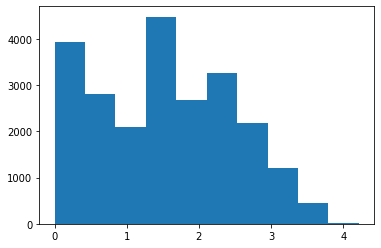

In [ ]:
def np_boxcox(y):
  return (np.power(y,ld)-1)/ld
def np_inv_boxcox(y):
  return np.exp(np.log(ld *y + 1 )/ld)

def real_mae(y_true,y_pred):
      return K.mean(K.abs(tf.math.round(y_pred)-y_true))

def inv_boxcox(y):
  return K.exp(K.log(ld * y + 1 )/ld)

def scaled_mae(y_true,y_pred):
  """ To use with scaled targets"""
  y_true = inv_boxcox(y_true)
  y_pred = inv_boxcox(y_pred)
  return real_mae(y_true,y_pred)
def LR(x):
    return leaky_relu(x, alpha=0.2)


train_data = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32}).set_index("authorID")
y_sc,ld= boxcox(train_data["h_index"].values)
y_train_sc = np_boxcox(y_train)
y_holdout_sc = np_boxcox(y_holdout)
plt.hist(y_sc,bins=10)

In [ ]:
class ResDense(tf.keras.Model):

  def __init__(self,size,activation,dropout_rate,bn=True,residual=True,*args):
    super(ResDense, self).__init__()
    
    
    self.bn = bn
    self.residual  = residual

    self.dense= Dense(size,activation=activation,*args)
    self.bn=BatchNormalization()
    self.dropout = Dropout(dropout_rate)
    
  def call(self,input,training=False):
    output = self.dense(input)
    output = self.dropout(output)
    if self.bn: output = self.bn(output)  
    if self.residual : output += input

    return output

In [ ]:
class Net(tf.keras.Model):
  """
  This model looks at each block of features separately 
  """
  def __init__(self):
    super(Net, self).__init__()
    self.dense11= Dense(64, activation=relu)  # LINE
    self.dense12= Dense(8, activation=relu)

    self.dense21= Dense(32, activation=relu) # Deep Walk
    self.dense22= Dense(8, activation=relu)


    self.dense31= Dense(32, activation=relu) # Keywords embedding
    self.dense32= Dense(8, activation=relu) 


    self.dense41= Dense(128, activation=relu) # mean Doc2vec
    self.dense42= Dense(8, activation=relu)

    self.dense51= Dense(128, activation=relu) # std Doc2vec
    self.dense52= Dense(8, activation=relu)


    self.dense61= Dense(128, activation=relu)  # max Doc2vec
    self.dense62= Dense(8, activation=relu)

    self.dense71= Dense(128, activation=relu) # min Doc2vec
    self.dense72= Dense(8, activation=relu)

    self.dense81= Dense(64, activation=relu) # graph features
    self.dense82= Dense(16, activation=relu)


    self.final_dense = Sequential([
        Dense(128, activation=relu),
        Dense(64,activation=relu),
        Dense(1)])


  def call(self,input):


    output1 = self.dense11(input[:,:128])  # LINE
    output1 = self.dense12(output1)


    output2 = self.dense21(input[:,128:192])  # Deep Walk
    output2 = self.dense22(output2)


    output3 = self.dense31(input[:,192:256]) # Keywords embedding
    output3 = self.dense32(output3)


    output4 = self.dense41(input[:,256:512]) # mean Doc2vec
    output4 = self.dense42(output4)

    output5 = self.dense51(input[:,512:768]) # std Doc2vec
    output5 = self.dense52(output5)


    output6 = self.dense61(input[:,768:1024]) # max Doc2vec
    output6 = self.dense62(output6)

    output7 = self.dense71(input[:,1024:1280]) # min Doc2vec
    output7 = self.dense72(output7)

    output8 = self.dense81(input[:,1280:]) # graph features
    output8 = self.dense82(output8)

    output = self.final_dense(tf.concat([output1,output2,output4,output3,output5,output6,output7,output8], 1))

    return output



In [ ]:
class Attention_Net(tf.keras.Model):

  """
  Model with attention mechanism

  """

  def __init__(self):
    super(Attention_Net, self).__init__()
    self.dense1 =Sequential([Dense(128, activation=relu),
                             Dense(64, activation=relu),
                             Dense(32, activation=relu),
                             Dense(16, activation=relu),
                             Dense(1, activation=relu)]) 
    self.dense2 = Sequential([Dense(128, activation=relu),
                             Dense(64, activation=relu),
                             Dense(32, activation=relu),
                             Dense(16, activation=relu),
                             Dense(1, activation=relu)]) 


    self.attention = Sequential([Dense(128, activation=relu),
                                 Dense(2,activation='softmax')]) 


  def call(self,input):


    output1 = self.dense1(tf.concat([input[:,:128] , input[:,192:256],input[:,768:1024],input[:,1024:1280], input[:,1280:]],1)) # LINE + Keywords embedding + min Doc2vec +max Doc2vec + graph features

    output2 = self.dense2(tf.concat([input[:,128:192],input[:,256:512],input[:,512:768], input[:,1280:]],axis=1))  # Deep walk  + mean Doc2vec +std Doc2vec +graph features

    attention = self.attention(input)

    output = tf.multiply(tf.stack([output1,output2],axis=2), tf.expand_dims(attention , axis=1))

    output = tf.reduce_sum(output, axis=[1,2])

    return output

In [ ]:
def train_model(scaled_targets=False,scaled_X=False,PCA=False,
                batch_size=200,n_layers=10,bn=True,residual=True,dropout=0.15,activation='lr'):

        
  
        if PCA : X = X_train_pca
        else : X = X_train

        patience = 100

        n_cols = X.shape[1]
      
        model = Sequential()
        #model.add(Dropout(dropout))
        for i in range(n_layers):
          model.add(ResDense(n_cols, activation=activation,dropout_rate=dropout,bn=bn,residual=residual))        
        
        model.add(Dense(300,activation=activation)) 
        model.add(Dropout(dropout))
        model.add(BatchNormalization())

        model.add(Dense(1,activation=activation))

        # Optimizer

        opt = NovoGrad(lr=lr)
        opt = tfa.optimizers.Lookahead(opt) ##WRAP OPTIMIZER WITH LookAhead layer 

        #########################################
        if scaled_targets : 
          Y = y_train_sc
          model.compile(optimizer=opt, loss="mae",metrics=[scaled_mae])
          # train model
          ##Early stopping
          es = tf.keras.callbacks.EarlyStopping(monitor='val_scaled_mae',restore_best_weights=True, patience=200,min_delta=0.05,verbose=2)
          reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_scaled_mae', factor=0.3, patience=100, mode='auto', min_delta=0.1,verbose=2)
          history=model.fit(X,Y,batch_size=batch_size,validation_split=0.2, epochs=1000,callbacks=[es,reduce_lr])
        
        else :

          Y = y_train
          model.compile(optimizer=opt, loss="mae",metrics=[real_mae])
          # # train model
          es = tf.keras.callbacks.EarlyStopping(monitor='val_real_mae',restore_best_weights=True, patience=patience*3,min_delta=0.1,verbose=1)
          reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='real_mae', factor=0.3, patience=patience, mode='auto', min_delta=0.1,verbose=1)
          history=model.fit(X,Y,batch_size=batch_size,validation_split=0.2, epochs=1000,callbacks=[es,reduce_lr])


        return model


In [ ]:
#pretrained_model = train_model(PCA=False,scaled_targets=False,dropout=0.0,batch_size=150,n_layers=10,residual=True,bn=True)      
# holdout_preds = pretrained_model.predict(X_holdout)
# #real_mae(inv_boxcox(holdout_preds),y_holdout)
# real_mae(holdout_preds,y_holdout)

# Boost performance with APPNP

In [ ]:
n_cols = df_full_sc.shape[1]
G_nx = nx.read_edgelist('collaboration_network.edgelist', delimiter=' ', nodetype=int)
G = StellarGraph.from_networkx(G_nx,node_features=df_full_sc, node_type_default="author", edge_type_default="cites")

In [ ]:
targets = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32})
targets.set_index("authorID",inplace=True)

median = np.median(targets['h_index'].values)
targets_shifted = pd.DataFrame(targets['h_index'].values - median, columns=['h_index'], index=targets.index)
targets_sc = pd.DataFrame(y_sc, columns=['h_index'], index=targets.index)

# Use scikit-learn to compute training and test sets

train_targets, val_targets = model_selection.train_test_split(targets, test_size=0.05)
train_targets_sc, val_targets_sc = model_selection.train_test_split(targets_sc, test_size=0.05)




generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)

train_gen = generator.flow(train_targets.index, train_targets)
val_gen = generator.flow(val_targets.index, val_targets)

train_gen_sc = generator.flow(train_targets.index, train_targets_sc)
val_gen_sc = generator.flow(val_targets.index, val_targets_sc)


test_gen = generator.flow(test_data["authorID"])


Using GCN (local pooling) filters...


In [ ]:
def fit_model_params(lr,n_layers=4,tp=0.5,dropout=0.15,bn=True,residual=True,lookahead=True,optimizer='Novograd',activation='elu',scaled=False):

      custom_appnp = APPNP(
        layer_sizes=[200],
        activations=[LR],
        generator=generator,
        teleport_probability=tp)

      feature_layers = []

      model = Sequential()

      for i in range(n_layers):
        model.add((ResDense(n_cols, activation=LR,dropout_rate=dropout,bn=bn)))
      
      model.add(Dense(100,activation=LR)) ## should be elu
      model.add(Dropout(dropout))
      if bn : model.add(BatchNormalization())
      model.add(Dense(1,activation=LR)) ## should be elu



      custom_appnp._feature_layers = [model]

      x_inp, x_out = custom_appnp.in_out_tensors()

      custom_appnp_model = tf.keras.models.Model(inputs=x_inp, outputs=x_out)
      if optimizer == 'Novograd':opt = NovoGrad(lr=lr)
      else : opt=tfa.optimizers.LAMB(learning_rate=lr)
      if lookahead: opt = tfa.optimizers.Lookahead(opt) ##WRAP OPTIMIZER WITH LookAhead layer 

      es,lr_schedule = callbacks()
      
      if scaled :
          custom_appnp_model.compile(loss="mae",metrics=[sclaed_mae],optimizer=opt)
          history=  custom_appnp_model.fit(train_gen_sc,epochs=2500,validation_data=val_gen_sc,shuffle=False,callbacks =[es,lr_schedule,NeptuneMonitor()])  # this should be False, since shuffling data means shuffling the whole graph                                     
      
      else : 
          custom_appnp_model.compile(loss="mae",metrics=[real_mae],optimizer=opt)
          history=  custom_appnp_model.fit(train_gen,epochs=2500,validation_data=val_gen,shuffle=False,callbacks=[es,lr_schedule,NeptuneMonitor()])  # this should be False, since shuffling data means shuffling the whole graph                                     

      return history


def callbacks():
  reduce_lr = ReduceLROnPlateau(monitor='val_real_mae', factor=0.5,mode = "min",patience=75, min_lr=1e-6,min_delta=0.066,verbose=1)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_real_mae',restore_best_weights=True, patience=200,min_delta=0.066,verbose=1)

  return [reduce_lr,es]

# Optuna for HP optimizaiton


In [ ]:
def objective(trial,input_size = df_full_sc.shape[0],):
      # We optimize the numbers of layers and their units.

      params = {
        'n_layers':trial.suggest_int("n_layers", 1,8),
        'tp':trial.suggest_uniform('tp',0.75,1),
        'scaled':False,
        'bn':trial.suggest_categorical('bn',[False,True]),
        'dropout':trial.suggest_uniform('dropout',0.0,0.6),
        'lr':trial.suggest_uniform('lr',1e-3,9e-2),
        'optimizer':trial.suggest_categorical('optmizer',['Novograd','LAMB']),
        'lookahead':trial.suggest_categorical('lookahead',[False,True]),
        'activation':trial.suggest_categorical('activation',['relu','lr','elu']),
        'residual': False,
      }
      print("***************************params*******************\n",params)
      history = fit_model_params(**params)
   
      
      return float(np.min(history.history["val_real_mae"]))

In [ ]:
import neptune
import neptunecontrib.monitoring.optuna as opt_utils
from neptunecontrib.monitoring.keras import NeptuneMonitor

neptune.init(api_token='ANONYMOUS', project_qualified_name='shared/optuna-integration')

def main():

    storage='sqlite:///APPNP_Optuna.db'
    # Create experiment
    neptune.create_experiment('optuna-sweep-advanced')
    # Create callback to log advanced options during the sweep
    neptune_callback = opt_utils.NeptuneCallback(log_study=True, log_charts=True)
    study = optuna.create_study(direction="minimize",storage=storage)
    study.optimize(objective, timeout=3*3600,n_jobs=1,callbacks=[neptune_callback])
    neptune.stop()
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return study,trial

In [ ]:
study,trial=main()

## Ensemble

In [ ]:
def appnp_model(lr,n_layers=4,tp=0.5,dropout=0.15,bn=True,residual=True,lookahead=True,optimizer='Novograd',activation='elu',scaled=False):

      custom_appnp = APPNP(
        layer_sizes=[200],
        activations=[LR],
        generator=generator,
        teleport_probability=tp)

      feature_layers = []

      model = Sequential()

      for i in range(n_layers):
        model.add((ResDense(n_cols, activation=LR,dropout_rate=dropout,bn=bn)))
      
      model.add(Dense(100,activation=LR)) ## should be elu
      model.add(Dropout(dropout))
      if bn : model.add(BatchNormalization())
      model.add(Dense(1,activation=LR)) ## should be elu



      custom_appnp._feature_layers = [model]

      x_inp, x_out = custom_appnp.in_out_tensors()

      custom_appnp_model = tf.keras.models.Model(inputs=x_inp, outputs=x_out)
      if optimizer == 'Novograd':opt = NovoGrad(lr=lr)
      else : opt=tfa.optimizers.LAMB(learning_rate=lr)
      if lookahead: opt = tfa.optimizers.Lookahead(opt) ##WRAP OPTIMIZER WITH LookAhead layer 
      custom_appnp_model.compile(loss="mae",metrics=[real_mae],optimizer=opt)


      return custom_appnp_model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

""" Tensorflow orginal early stopping call back does not restore best weights like it should """

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

n_cols = df_full_sc.shape[1]

#params = {'n_layers': 4, 'tp': 0.9939236776191182, 'bn': True, 'dropout': 0.4026519014278893, 'lr': 0.02205957618270451, 'optimizer': 'LAMB', 'lookahead': False, 'activation': 'lr'}
#params = {'n_layers': 6, 'tp': 0.7513095895530512, 'bn': False, 'dropout': 0.18498022320223975, 'lr': 0.07189637001413784, 'optimizer': 'Novograd', 'lookahead': True, 'activation': 'lr'}
params = {'n_layers': 6, 'tp': 0.8954708163270214, 'bn': False, 'dropout': 0.5157525345254237, 'lr': 0.07301861599956465, 'optimizer': 'LAMB', 'lookahead': False, 'activation': 'relu'}
custom_appnp_model = appnp_model(**params)

reduce_lr = ReduceLROnPlateau(monitor='val_real_mae', factor=0.5,mode = "min",patience=75, min_lr=1e-6,min_delta=0.066,verbose=1)
es = ReturnBestEarlyStopping(monitor='val_real_mae',restore_best_weights=True, patience=250,min_delta=0.066,verbose=1)


history=custom_appnp_model.fit(train_gen,epochs=2500,validation_data=val_gen,shuffle=False,callbacks =[reduce_lr,es])  # this should be False, since shuffling data means shuffling the whole graph                                     


3.5246327

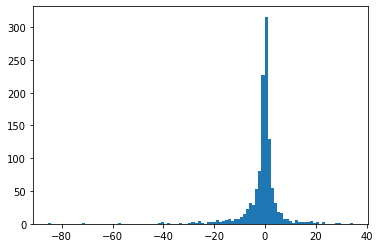

In [ ]:
""" Verify model predictions

Loss on validation data isn't the same as tensorflow ...""""

from sklearn.metrics import mean_absolute_error as mae


float(np.min(history.history["val_real_mae"]))
y_val = custom_appnp_model.predict(val_gen)
diff = y_val.reshape(-1)-val_targets.values.reshape(-1)
diff2 = np.round(y_val.reshape(-1))-val_targets.values.reshape(-1)
z=plt.hist(diff,bins=100)

mae(np.round(y_val.reshape(-1)),val_targets.values.reshape(-1))



In [ ]:
""" Write predictions into file """

y_pred = custom_appnp_model.predict(test_gen)
# write the predictions to file
test_data['h_index_pred'].update(pd.Series(np.round_(y_pred.reshape(-1))))
test_data.loc[:,["authorID","h_index_pred"]].to_csv('test_predictions.csv', index=False)


# Bagging ensemble (sounds cool doesn't work)

In [ ]:
zfrom sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


class EnsembleModel(BaseEstimator):
    def __init__(self, n_folds=5):
        #self.meta_model = meta_model
        self.n_folds = n_folds
        self.params = params
   
    # We again fit the data on clones of the original models
    def fit(self,generator,train_data):
        n_cols = df_full_sc.shape[1]
        self.trained_models = []
        

        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        self.model_losses = []
  
        for train, val in kfold.split(train_data.index):
            train_index,val_index = train_data.index.values[train],train_data.index.values[val]
            instance = appnp_model(**self.params)
            self.trained_models.append(instance)
            train_generator = generator.flow(train_index, train_data.loc[train_index])
            val_generator = generator.flow(val_index, train_data.loc[val_index])
            history = instance.fit(train_generator,validation_data = val_generator,epochs=2000,shuffle=False,callbacks=callbacks())    
            self.model_losses.append(float(np.min(history.history["val_real_mae"])))

        
        return self
   
        
    def predict(self, test_generator):
      
      return np.vstack([model.predict(test_generator) for model in self.trained_models]).reshape(self.n_folds,-1).mean(axis=0)



ensemble = EnsembleModel(n_folds=6)
ensemble.fit(generator,train_data)
    